In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [2]:
from pyspark.sql.functions import col, udf, rand, count, desc, trim
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType, StringType

In [3]:
spark = SparkSession.builder.getOrCreate()

22/10/28 10:02:18 WARN Utils: Your hostname, PMachine resolves to a loopback address: 127.0.1.1; using 192.168.0.80 instead (on interface wlxe8de271baab4)
22/10/28 10:02:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/28 10:02:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 1. Narysuj wykres zależności kolumn Plot Infant mortality vs. Literacy dla 30 najbogatszych i 30 najbiedniejszych krajów

In [4]:
countries = spark.read.csv("countries of the world.csv",inferSchema=True,header=True)
countries.createOrReplaceTempView("countries")
countries.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (sq. mi.): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



In [5]:
def to_float (s) :
   return float(s.replace(',','.'))
float_udf = udf(to_float , FloatType())

In [6]:
full_countries = countries.select('Country', 'Population', 'Literacy (%)', 'GDP ($ per capita)',"Infant mortality (per 1000 births)").na.drop()
full_countries = full_countries.withColumn("Infant mortality (per 1000 births)", float_udf("Infant mortality (per 1000 births)"))
full_countries.createOrReplaceTempView("full_countries")
full_countries.show()
full_countries.printSchema()

+------------------+----------+------------+------------------+----------------------------------+
|           Country|Population|Literacy (%)|GDP ($ per capita)|Infant mortality (per 1000 births)|
+------------------+----------+------------+------------------+----------------------------------+
|      Afghanistan |  31056997|        36,0|               700|                            163.07|
|          Albania |   3581655|        86,5|              4500|                             21.52|
|          Algeria |  32930091|        70,0|              6000|                              31.0|
|   American Samoa |     57794|        97,0|              8000|                              9.27|
|          Andorra |     71201|       100,0|             19000|                              4.05|
|           Angola |  12127071|        42,0|              1900|                            191.19|
|         Anguilla |     13477|        95,0|              8600|                             21.03|
|Antigua &

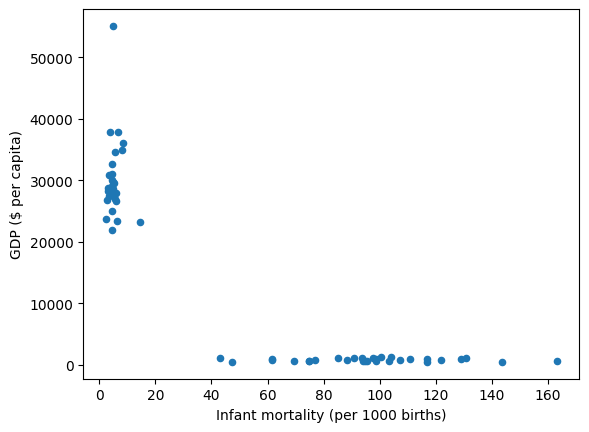

In [7]:
# używam podzapytań sql aby wybrać 30 najbogatszych i najbiedniejszych krajów
spark.sql(
    """
    SELECT `Infant mortality (per 1000 births)`,`GDP ($ per capita)` FROM full_countries where
    Country in (Select Country from full_countries order by `GDP ($ per capita)` asc limit 30) or
    Country in (Select Country from full_countries order by `GDP ($ per capita)` desc limit 30)
    """
).toPandas().plot.scatter(x='Infant mortality (per 1000 births)',y="GDP ($ per capita)")
plt.show()

### 2. Wczytaj zbiór danych "airports.csv" ...
ze strony https://www.kaggle.com/jonatancr/airports (zawiera on dane na temat lotnisk z całego świata). Ponieważ w zbiorze tym nie ma nagłówka, nadaj własne nazwy kolumnom, korzystając z opisu pliku na stronie https://openflights.org/data.html. Narysuj na wykresie (mapie) położenia wszystkich/wybranych lotnisk.


In [8]:
# Wczytanie danych oraz nazwanie odpowiednio kolumn
airports = spark.read.csv('airports.csv',header=False,inferSchema=True)
airports = airports.toDF("Airport ID",'Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','TZ database time zone','Type','Source')
airports.createOrReplaceTempView("airports")
airports.printSchema()


root
 |-- Airport ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude: integer (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- DST: string (nullable = true)
 |-- TZ database time zone: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Source: string (nullable = true)



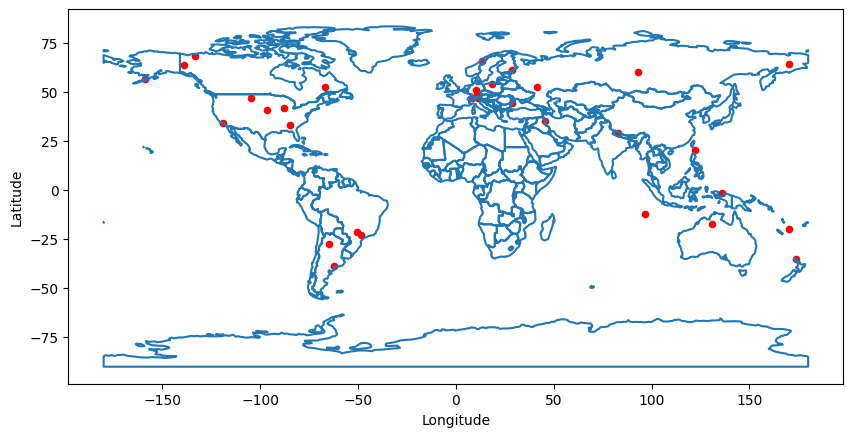

In [9]:
# Narysowanie losowej liczby lotnisk na mapie świata
limit_rows = 32#airports.count()
temp = airports.orderBy(rand()).limit(limit_rows).select("Latitude","Longitude").toPandas()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)

world.boundary.plot(ax=ax)
temp.plot.scatter(x="Longitude", y="Latitude",c='red', ax=ax)

plt.show()

### 3. Dla każdego kraju znaleź lotnisko której jest najbliżej Bieguna Południowego

In [10]:
# Wykorzystuję do tego podzapytania SQL - wyszukuję minimalną szerokość geograficzną, a następnie
# wyniki łączę z całą tabelą. Dzięki temu otrzymuję nazwę miasta oraz lotniska
spark.sql(
    """
    with temp (select Country, min(Latitude) as Latitude from airports group by country) 
    Select Country, City, Name, Latitude from airports a join temp t using(Country,Latitude)
    """
).show()

+----------------+--------------+--------------------+------------------+
|         Country|          City|                Name|          Latitude|
+----------------+--------------+--------------------+------------------+
|         Iceland|Vestmannaeyjar|Vestmannaeyjar Ai...| 63.42430114746094|
|          Canada|       Windsor|     Windsor Airport| 42.27560043334961|
|           Benin|       Cotonou|   Cadjehoun Airport| 6.357230186462402|
|    Burkina Faso|Bobo-dioulasso|Bobo Dioulasso Ai...|11.160099983215332|
|           Ghana|      Takoradi|    Takoradi Airport| 4.896059989929199|
|   Cote d'Ivoire|     San Pedro|   San Pedro Airport| 4.746719837188721|
|           Niger|         Diffa|       Diffa Airport|13.372900009155273|
|         Tunisia|      El Borma|    El Borma Airport|31.704299926757812|
|            Togo|          Lome| Lomé-Tokoin Airport| 6.165609836578369|
|         Belgium|       Bertrix| Jehonville Air Base|49.891700744628906|
|         Finland|         Hanko|     

### 4. Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju.
 - Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
 - Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy.


In [11]:
def process_country_name(s):
    s = s.replace("&", "and") \
        .replace("Rep.", "Republic") \
        .replace("Korea, North", "North Korea") \
        .replace("Korea, South", "South Korea") 
    
    return s.strip()

process_country_name_udf = udf(
    lambda s: process_country_name(s),
    StringType()
)

In [12]:
# Największy problem w tym zadaniu było porównanie nazw państw. Początkowo próbowałem połączyć tabele przy
# pomocy spark.sql, ale opertor 'like' w złączeniu nie działał. Dopiero obcięcię nazw z nadmiarowych znaków białych
# pozwoliło na połączenie tabel.

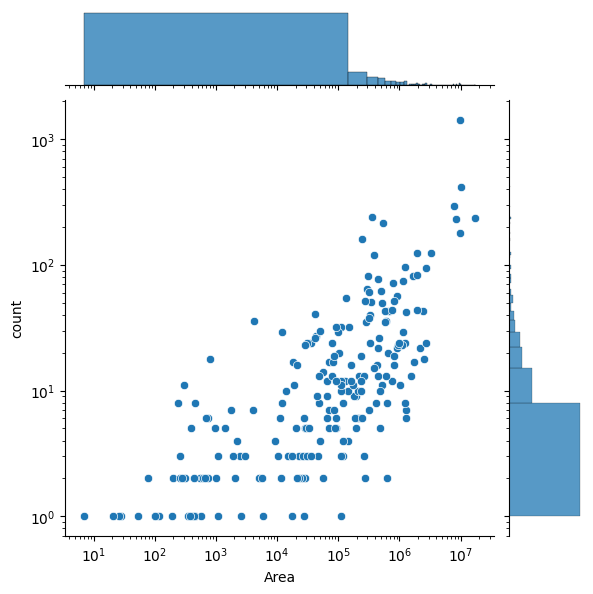

In [13]:
df_temp = countries.withColumn("Country",process_country_name_udf("Country"))\
    .withColumnRenamed("Area (sq. mi.)", "Area")\
    .join(airports,on="Country",how="inner")\
    .select(col("Country"),col("Area"))\
    .groupBy("Country")\
    .agg(F.count("Area"), F.max("Area"))\
    .withColumnRenamed("max(Area)","Area")\
    .withColumnRenamed("count(Area)","count")\
    .toPandas()

sns.jointplot(data=df_temp,x="Area",y="count")
plt.xscale("log")
plt.yscale("log")
plt.show()

### 5. Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym.

In [14]:
# Znów problemem są nazwy. Tym razem regionów. Trzeba je odpowiednio przemapować. Później to praktycznie powtórzenie
# poprzedniego ćwiczenia.

In [15]:
def process_continent_name(s):
    mapping = {
        "ASIA": "Asia",
        "AFRICA": "Africa",
        "BALTICS": "Europe",
        "EUROPE": "Europe",
        "IND. STATES": "Asia",
        "LATIN AMER": "South America",
        "NEAR EAST": "Asia",
        "NORTHERN AMERICA": "North America",
        "OCEANIA": "Australia/Oceania",
    }
    
    for i in mapping:
        if i in s:
            return mapping[i]
        
process_continent_name_udf = udf(
    lambda s: process_continent_name(s),
    StringType()
)

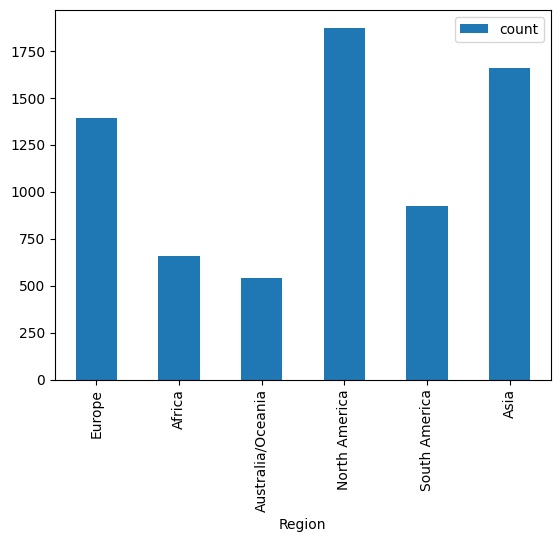

In [16]:
countries.withColumn("Country",process_country_name_udf("Country"))\
    .withColumnRenamed("Area (sq. mi.)", "Area")\
    .join(airports,on="Country",how="inner")\
    .select(col("Region"),col("Area"))\
    .withColumn("Region",process_continent_name_udf("Region"))\
    .groupBy("Region")\
    .agg(F.count("Area"))\
    .withColumnRenamed("count(Area)","count")\
    .toPandas().plot.bar(x="Region")

plt.show()